In [80]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from keras.utils import load_img
train_images = sorted(os.listdir('./data/images/train/all/'))
!TF_CPP_MIN_LOG_LEVEL=2
import matplotlib.pyplot as plt

In [81]:
train_image = []
for im in train_images:
    img = load_img('./data/images/train/all/'+ im, target_size=(300,300), color_mode= 'grayscale')
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
train_df = np.array(train_image)

In [82]:
def show_img(dataset):
    f, ax = plt.subplots(1,5)
    f.set_size_inches(40, 20)
    for i in range(5,10):
        ax[i-5].imshow(dataset[i].reshape(300,300), cmap='gray')
    plt.show()

In [114]:
def add_noice(image):
    row,col,ch= image.shape
    mean = 0
    sigma = 1
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss*0.3
    return noisy

In [115]:
noised_df= []

for img in train_df:
    noisy= add_noice(img)
    noised_df.append(noisy)

In [116]:
noised_df= np.array(noised_df)

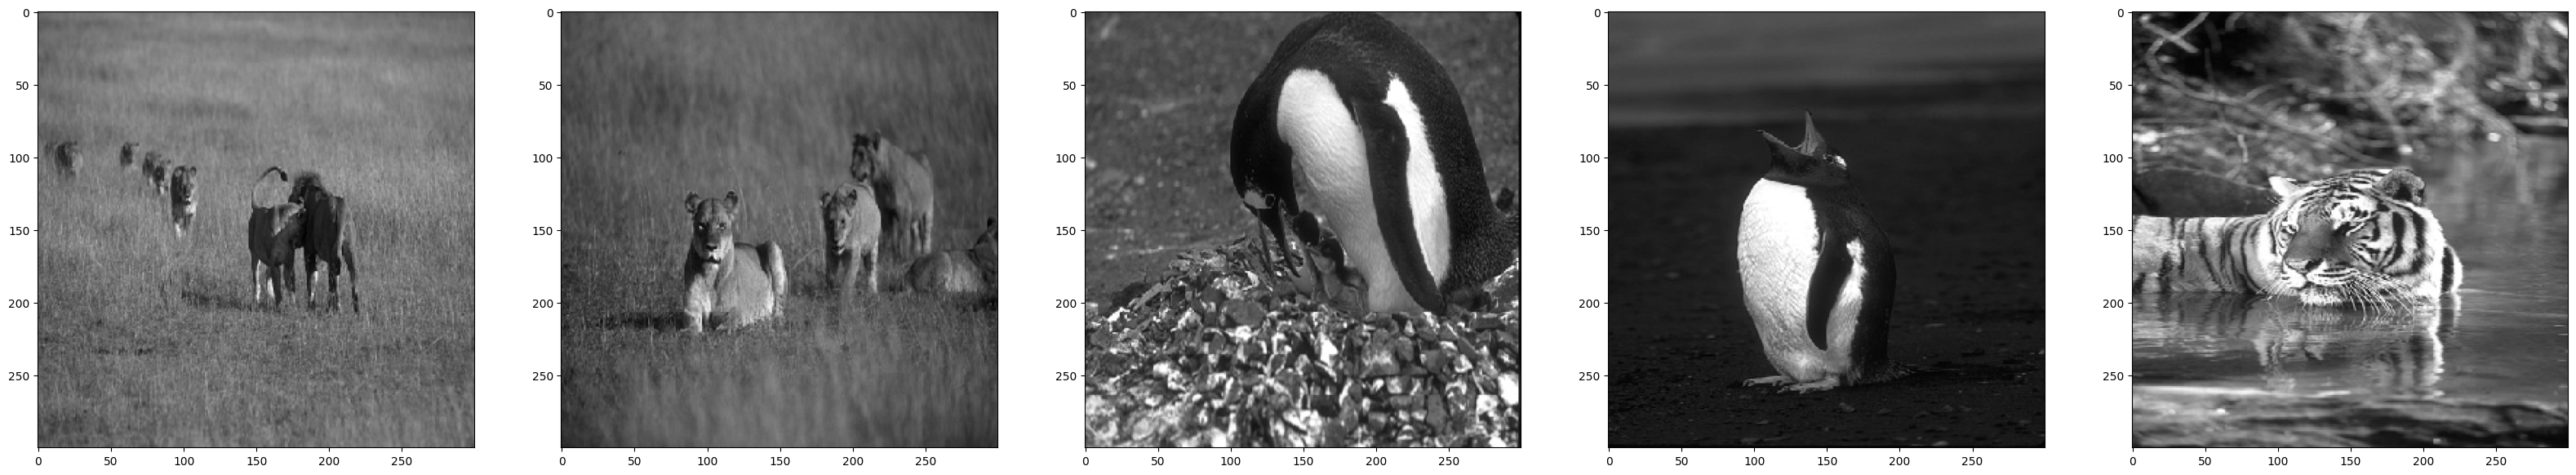

In [117]:
show_img(train_df)

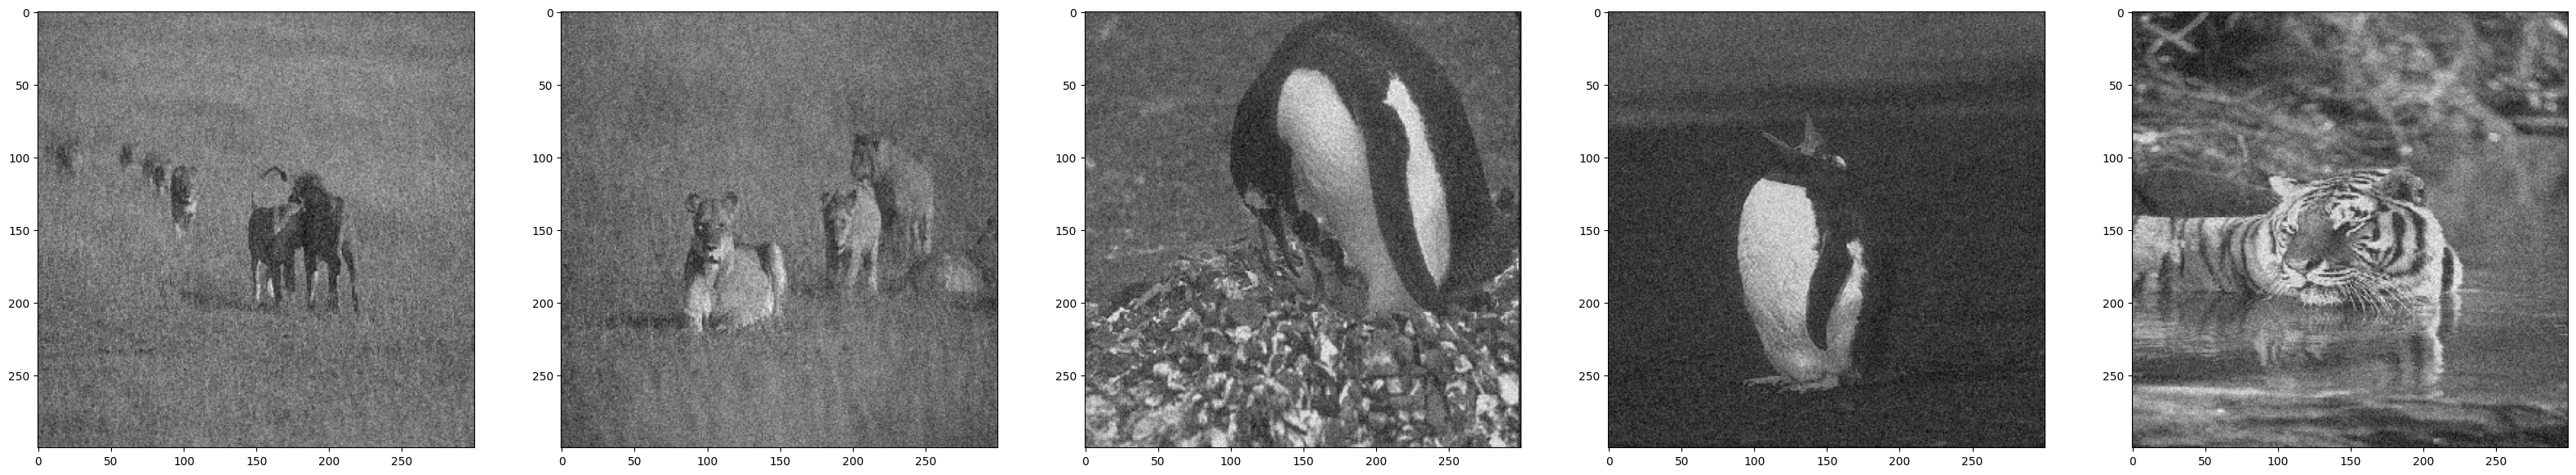

In [87]:
show_img(noised_df)

In [88]:
noised_df.shape

(200, 300, 300, 1)

In [89]:
train_df.shape

(200, 300, 300, 1)

In [90]:
xnoised= noised_df[0:100]
xtest= noised_df[100:]

In [91]:
xnoised.shape

(100, 300, 300, 1)

In [92]:
xtest.shape

(100, 300, 300, 1)

In [93]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D ,UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K

def autoencoder():
    
    input_img = Input(shape=(300,300,1), name='image_input')
    
    #enoder 
    x = Conv2D(300, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(300, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
    
    #decoder
    x = Conv2D(300, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(300, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return autoencoder

In [128]:
model= autoencoder()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 300, 300, 1)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 300, 300, 300)     3000      
                                                                 
 pool1 (MaxPooling2D)        (None, 150, 150, 300)     0         
                                                                 
 Conv2 (Conv2D)              (None, 150, 150, 300)     810300    
                                                                 
 pool2 (MaxPooling2D)        (None, 75, 75, 300)       0         
                                                                 
 Conv3 (Conv2D)              (None, 75, 75, 300)       810300    
                                                                 
 upsample1 (UpSampling2D)    (None, 150, 150, 300)     0   

In [95]:
from tensorflow.keras.callbacks import EarlyStopping

In [96]:
#training and saving the model to mdoel.model folder
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
model.fit(xnoised, xnoised, epochs=20, batch_size=2, validation_data=(xtest, xtest), callbacks=[early_stopping])
model.save("model.model")

In [104]:
tf.config.run_functions_eagerly(True)
model = tf.keras.models.load_model('model.model')
xtrain= train_df[100:]

1/1 [==============================] - 2s 2s/step


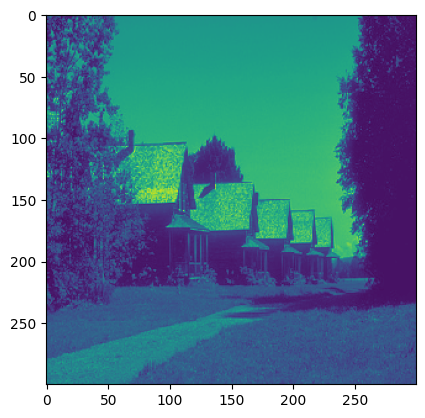

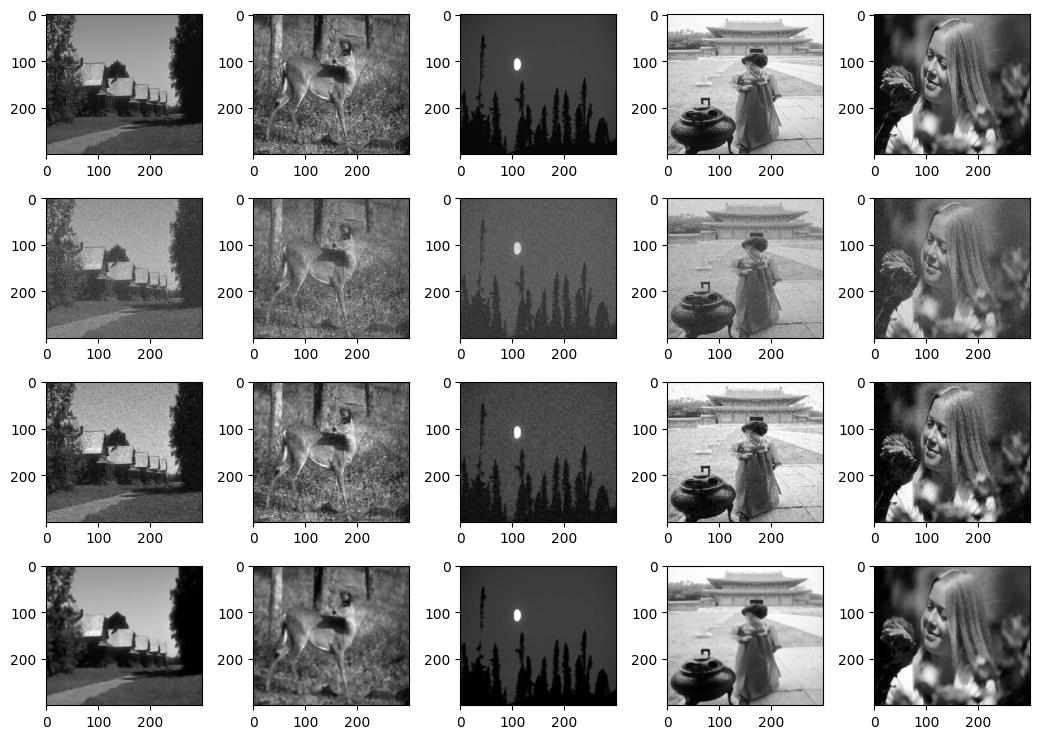

In [118]:
import cv2

pred= model.predict(xtest[:5])
plt.imshow(np.reshape(xtrain[0], (300,300)))
def plot_predictions(y_true, y_pred):    
    f, ax = plt.subplots(4, 5)
    f.set_size_inches(10.5,7.5)
    for i in range(5):
        ax[0][i].imshow(np.reshape(xtrain[i], (300,300)), aspect='auto', cmap='gray')
        ax[1][i].imshow(np.reshape(y_true[i], (300,300)), aspect='auto', cmap='gray')
        ax[2][i].imshow(np.reshape(y_pred[i], (300,300)), aspect='auto', cmap='gray')
        ax[3][i].imshow(cv2.medianBlur(xtrain[i], (5)), aspect='auto', cmap='gray')
       
    plt.tight_layout()
plot_predictions(xtest[:5], pred[:5])

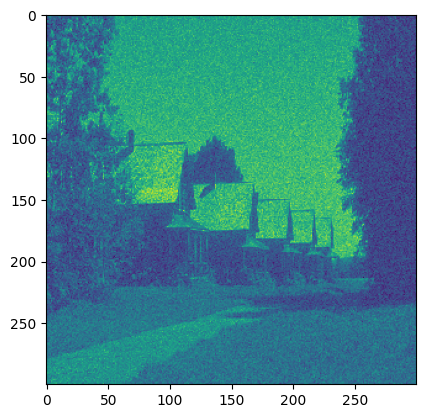

In [120]:
plt.imshow(np.reshape(xtest[0],(300,300)))

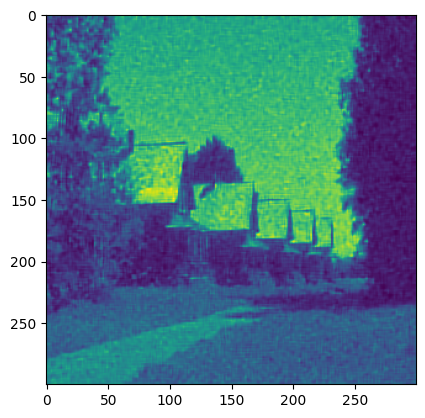

In [121]:
plt.imshow(np.reshape(pred[0],(300,300)))

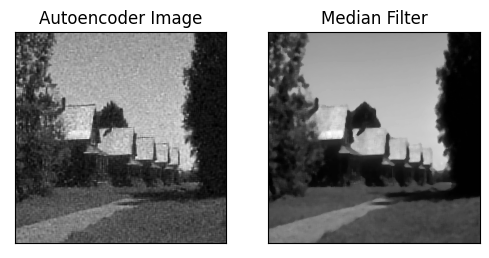

In [126]:
new_image = cv2.medianBlur(xtrain[0], (5))
plt.figure(figsize=(6,3))
plt.subplot(121)
plt.imshow(pred[0].reshape(300,300), cmap='gray')
plt.title('Autoencoder Image')
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(new_image, cmap='gray')
plt.title('Median Filter')
plt.xticks([])
plt.yticks([])
plt.show()

In [127]:
from math import log10, sqrt 
  
def PSNR(original, denoiced): 
    mse = np.mean((original - denoiced) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 
  
value1 = PSNR(xtest[0], new_image)
value2 = PSNR(xtest[0], pred[0])

print(f"PSNR value for Denoised image is {value2} dB while for Median filtered image is {value1} dB")

PSNR value for Denoised image is 70.37350503458418 dB while for Median filtered image is 58.40860819582372 dB


In [129]:
!pip install bm3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.7 MB/s eta 0:00:005.9 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 5.2 MB/s eta 0:00:00m eta 0:00:010:00:01


In [144]:
#!pip install opencv-python


#Denoising using BM3D¶

In [132]:
import bm3d

In [137]:
denoised_image = bm3d.bm3d(xtest[0], sigma_psd=30/255, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)

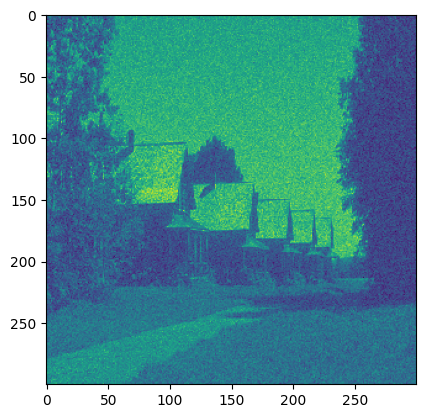

In [139]:
plt.imshow(xtest[0])

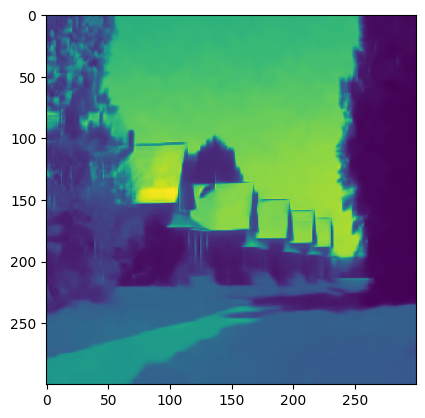

In [140]:
plt.imshow(denoised_image)

In [143]:
value1 = PSNR(xtest[0], new_image)
value2 = PSNR(xtest[0], denoised_image)
print(f"PSNR value for Denoised image is {value2} dB while for Median filtered image is {value1} dB")

PSNR value for Denoised image is 58.470294278208456 dB while for Median filtered image is 58.40860819582372 dB
